<a href="https://colab.research.google.com/github/kalebsampaco/Ejercicios-en-google-colab/blob/master/redes_adversas_generativas_srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 tiempo: 0:01:44.956725


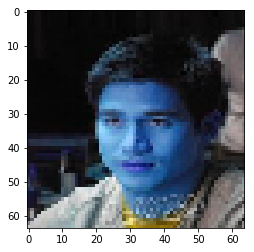

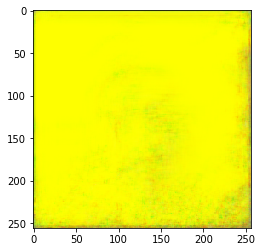

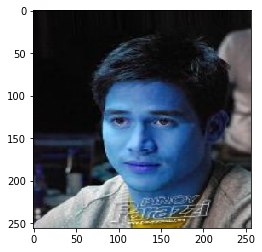

0 CHECKPOINT


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50 tiempo: 0:08:43.734940


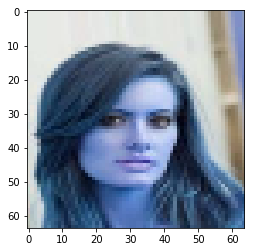

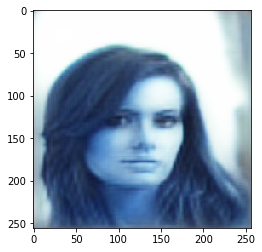

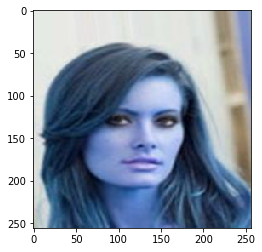

50 CHECKPOINT
100 tiempo: 0:15:30.311809


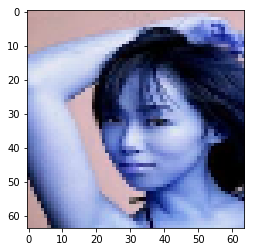

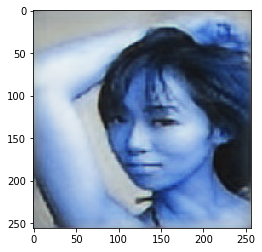

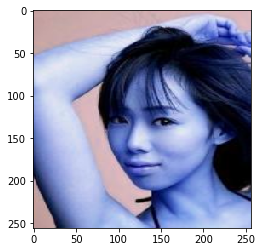

100 CHECKPOINT
150 tiempo: 0:22:09.629114


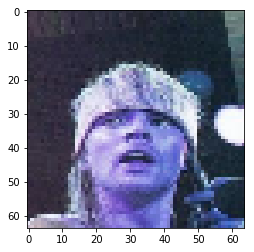

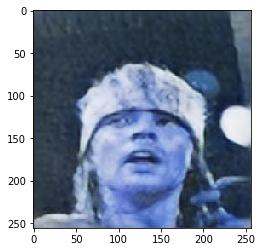

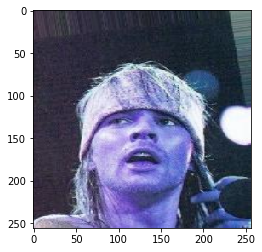

150 CHECKPOINT
200 tiempo: 0:28:44.487310


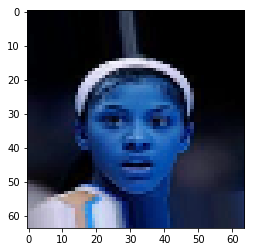

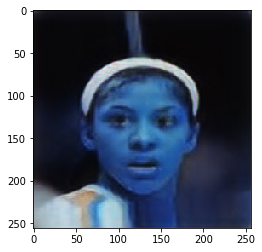

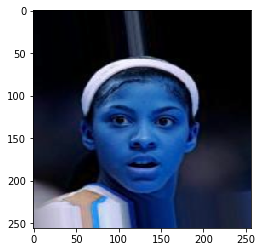

200 CHECKPOINT
250 tiempo: 0:34:50.372961


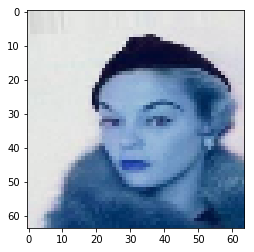

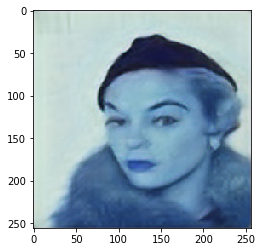

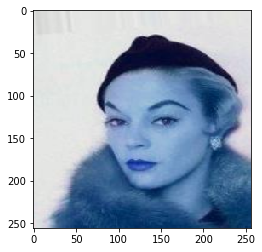

250 CHECKPOINT
300 tiempo: 0:40:58.583715


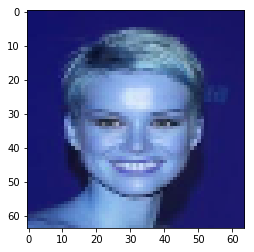

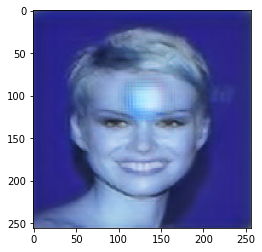

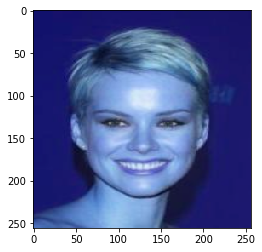

300 CHECKPOINT
350 tiempo: 0:47:04.449057


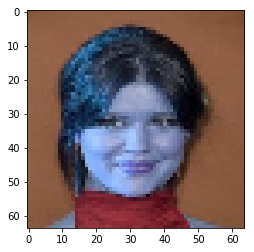

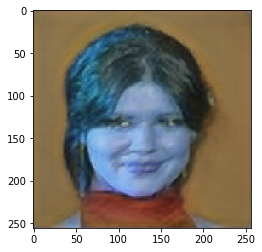

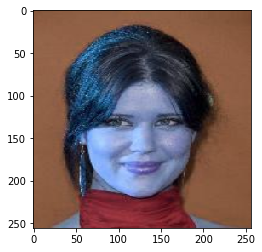

350 CHECKPOINT
400 tiempo: 0:52:45.300380


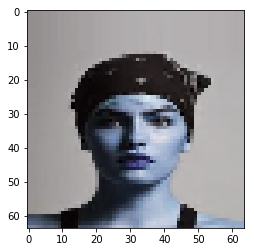

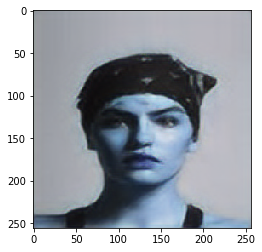

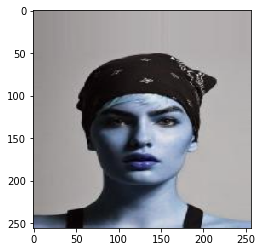

400 CHECKPOINT
450 tiempo: 0:58:26.227273


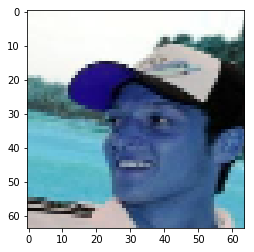

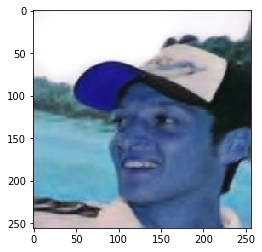

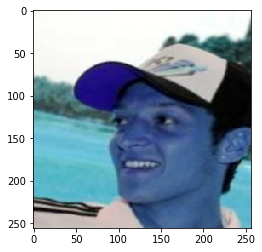

450 CHECKPOINT
500 tiempo: 1:04:13.933299


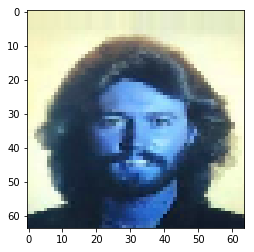

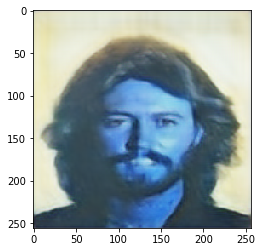

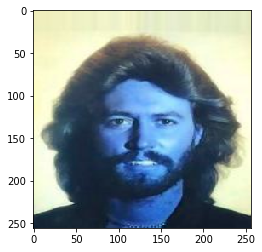

500 CHECKPOINT
550 tiempo: 1:09:49.550153


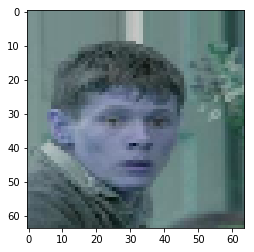

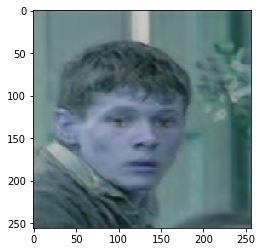

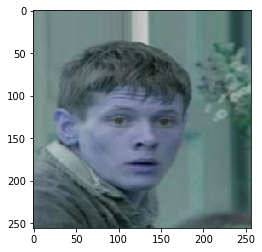

550 CHECKPOINT
600 tiempo: 1:15:10.012042


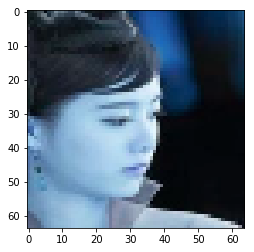

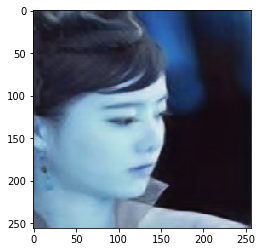

In [0]:

import cv2 as cv
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

class Cargador_Datos():#FUNCION DE CARGADO DE DATOS
    def __init__(self, nombre_dataset, tamano_imagen=(128, 128)):
        self.nombre_dataset = nombre_dataset
        self.tamano_imagen = tamano_imagen

    def load_data(self, tamano_batch=1, test=False):#CARGADO DE DATASET E IMAGENES DE ENTRENAMIENTO
        tipo_de_datos = "train" if not test else "test"

        
        ruta = glob('/content/drive/My Drive/srgan/images/%s/*' % (self.nombre_dataset))
        batch_images = np.random.choice(ruta, size=tamano_batch)

        alta_resolucion = []
        baja_resolucion = []
        for ruta_imagen in batch_images:
            img = self.imread(ruta_imagen)

            alto, ancho = self.tamano_imagen
            alto_baja, ancho_baja = int(alto / 4), int(ancho / 4)

            imagen_hq = cv.resize(img, self.tamano_imagen)
            imagen_lq = cv.resize(img, (alto_baja, ancho_baja))

            # Aumento de datos solo en entrenamiento
            if not test and np.random.random() < 0.5:
                imagen_hq = np.fliplr(imagen_hq)
                imagen_lq = np.fliplr(imagen_lq)

            alta_resolucion.append(imagen_hq)
            baja_resolucion.append(imagen_lq)

        #ESCALADO Y NORMALIZACION ENTRE 1 Y -1
        alta_resolucion = np.array(alta_resolucion) / 127.5 - 1.
        baja_resolucion = np.array(baja_resolucion) / 127.5 - 1.

        return alta_resolucion, baja_resolucion#ACUMULACION EN ALTA Y BAJA RESOLUCION


    def imread(self, ruta):
        return cv.imread(ruta).astype(np.float)
      
      
      

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/srgan/')
import keras.backend as K

class SRGAN():
    def __init__(self):
        # Variables de entrada
        self.canales = 3
        self.alto_baja_resolucion = 64                 #ALTO DE BAJA RESOLUCION
        self.ancho_baja_resolucion = 64                  # ANCHO DE BAJA RESOLUCION
        self.tamano_baja_resolucion = (self.alto_baja_resolucion, self.ancho_baja_resolucion, self.canales)
        self.alto_alta_resolucion = self.alto_baja_resolucion*4   # ALTO DE ALTA RESOLUCION
        self.ancho_alta_resolucion = self.ancho_baja_resolucion*4     # ANCHO DE ALTA RESOLUCION
        self.tamano_alta_resolucion = (self.alto_alta_resolucion, self.ancho_alta_resolucion, self.canales)

        # BLOQUES RESIDUALES DEL GENERADOR
        self.numero_bloques_residuales = 16

        optimizador = Adam(0.0002, 0.5)#DEFINICION DE OPTIMIZADOR

        # DEFINICION DE VGG PREENTRENADA PARA EXTRACCION DE CARACTERISTICAS
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse',optimizer=optimizador,metrics=['accuracy'])

        # CONFIGURACION DE CARGADOR DE DATOS
        self.nombre_dataset = 'img_align_celeba'
        self.carga_datos = Cargador_Datos(nombre_dataset=self.nombre_dataset,tamano_imagen=(self.alto_alta_resolucion, self.ancho_alta_resolucion))

        # Configuracion del shape de salida del discriminador
        parche = int(self.alto_alta_resolucion / 2**4)
        self.parche_discriminador = (parche, parche, 1)

        # Filtros de las primeras capas de generaddor y discriminador
        self.gf = 64
        self.df = 64

        # creacion y compilacion de discriminador
        self.discriminador = self.crear_discriminador()
        self.discriminador.compile(loss='mse',optimizer=optimizador,metrics=['accuracy'])

        # creacion del generador
        self.generador = self.build_generator()

        # definicion de imagenes de baja y alta resolucion
        imagen_hq = Input(shape=self.tamano_alta_resolucion)
        imagen_lq = Input(shape=self.tamano_baja_resolucion)

        # Generacion de imagenes de alta resolucion a traves de las de baja resolucion
        falsa_alta_resolucion = self.generador(imagen_lq)

        # Obtencion de caracteristicas de las imagenes generadas
        caracteristicas_falsas = self.vgg(falsa_alta_resolucion)

        # Congelacion del discriminador de cara al modelo conjunto
        self.discriminador.trainable = False

        # Validez juzgada a traves del discriminador
        validez = self.discriminador(falsa_alta_resolucion)

        self.combinado = Model([imagen_lq, imagen_hq], [validez, caracteristicas_falsas])
        self.combinado.compile(loss=['binary_crossentropy', 'mse'],loss_weights=[1e-3, 1],optimizer=optimizador)

    #Creacion de modelo VGG19 preentrenado
    def build_vgg(self):
 
        vgg = VGG19(weights="imagenet")
        
        #obtencion de las salidas de las capas convolucionales intermedias
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.tamano_alta_resolucion)

        # Extraccion de caracteristicas
        img_features = vgg(img)

        # Remodelacion de modelo vgg para extraer caraacteristicas solo  
        return Model(img, img_features)

    #Creacion de generador
    def build_generator(self):
        
        #Definicion de bloques residuales
        def bloque_residual(entrada_capa, filtros):         
            x1 = Conv2D(filtros, kernel_size=3, strides=1, padding='same')(entrada_capa)
            x2 = Activation('relu')(x1)
            x3 = BatchNormalization(momentum=0.8)(x2)
            x4 = Conv2D(filtros, kernel_size=3, strides=1, padding='same')(x3)
            x5 = BatchNormalization(momentum=0.8)(x4)
            x6 = Add()([x5, entrada_capa])
            return x6

        #Definicion de aproximacion de deconvolucion  
        def deconv2d(entrada_capa):
            u1 = UpSampling2D(size=2)(entrada_capa)
            u2 = Conv2D(256, kernel_size=3, strides=1, padding='same')(u1)
            u3 = Activation('relu')(u2)
            return u3

        #Entrada de baja resolucion
        imagen_lq = Input(shape=self.tamano_baja_resolucion)
        c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(imagen_lq)
        c1 = Activation('relu')(c1)

        # Anidado de bloques residuales
        r = bloque_residual(c1, self.gf)
        for _ in range(self.numero_bloques_residuales - 1):
            r = bloque_residual(r, self.gf)

        # Deconvoluciones y generacion de imagen de alta resolucion
        c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)
        alta_resolucion_generada = Conv2D(self.canales, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(imagen_lq, alta_resolucion_generada)
    
    #Creacion del discriminador
    def crear_discriminador(self):
      
        #Bloques de discriminacion
        def bloque_discriminador(entrada_capa, filtros, strides=1, bn=True):
            x = Conv2D(filtros, kernel_size=3, strides=strides, padding='same')(entrada_capa)
            if bn:
                x = BatchNormalization(momentum=0.8)(x)
            x = LeakyReLU(alpha=0.2)(x)
            return x

        # Entrada y extraccion de caracteristicas
        d0 = Input(shape=self.tamano_alta_resolucion)
        d1 = bloque_discriminador(d0, self.df, bn=False)
        d2 = bloque_discriminador(d1, self.df, strides=2)
        d3 = bloque_discriminador(d2, self.df*2)
        d4 = bloque_discriminador(d3, self.df*2, strides=2)
        d5 = bloque_discriminador(d4, self.df*4)
        d6 = bloque_discriminador(d5, self.df*4, strides=2)
        d7 = bloque_discriminador(d6, self.df*8)
        d8 = bloque_discriminador(d7, self.df*8, strides=2)
        #Clasificacion de salida
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validez = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validez)

    #Funcion de entrenamiento
    def entrenar(self, epocas, tamano_batch=1, intervalo_muestra=50):

        tiempo_inicio = datetime.datetime.now()
        self.combinado.save_weights('/content/drive/My Drive/srgan/saved_model/combined.h5')
        self.discriminador.save_weights('/content/drive/My Drive/srgan/saved_model/discriminator.h5')
        self.generador.save_weights('/content/drive/My Drive/srgan/saved_model/generator.h5')
        for epoca in range(epocas):
            
            #Proceso de entrenamiento durante x epocas

            # Cargado de imagenes de alta y baja resolucion
            alta_resolucion, baja_resolucion = self.carga_datos.load_data(tamano_batch)

            # generacion de imagenes de alta resolucion a partir de las de baja resolucion
            falsa_alta_resolucion = self.generador.predict(baja_resolucion)

            # asignacion de etiquetas de valided a las imagenes reales y falsas  
            valido = np.ones((tamano_batch,) + self.parche_discriminador)
            falso = np.zeros((tamano_batch,) + self.parche_discriminador)

            # Entrenamiento del discriminador 
            perdidas_discriminador_real = self.discriminador.train_on_batch(alta_resolucion, valido)
            perdidas_discriminador_falsa = self.discriminador.train_on_batch(falsa_alta_resolucion, falso)
            perdidas_discriminador = 0.5 * np.add(perdidas_discriminador_real, perdidas_discriminador_falsa)

            #Entrenamiento del generador

            # Cargado de imagenes de alta y baja resolucion
            alta_resolucion, baja_resolucion = self.carga_datos.load_data(tamano_batch)

            # etiquetado de las imagenes generadas como reales para que forzar que el generador engañe al discriminador
            valido = np.ones((tamano_batch,) + self.parche_discriminador)

            # Obtencion de caracteristicas de alta resolucion con VGG
            caracteristicas_imagen = self.vgg.predict(alta_resolucion)

            # Entrenamiento del generador con el discriminador congelado
            perdidas_generador = self.combinado.train_on_batch([baja_resolucion, alta_resolucion], [valido, caracteristicas_imagen])

            tiempo_resultante = datetime.datetime.now() - tiempo_inicio
           

            # Guardado de imágenes y modelos con x intervalo de tiempo
            if epoca % intervalo_muestra == 0:
                print ("%d tiempo: %s" % (epoca, tiempo_resultante))
                self.imagenes_muestra(epoca)
                print ("%d CHECKPOINT" % (epoca))
                self.combinado.save_weights('/content/drive/My Drive/srgan/saved_model/combined.h5')
                self.discriminador.save_weights('/content/drive/My Drive/srgan/saved_model/discriminator.h5')
                self.generador.save_weights('/content/drive/My Drive/srgan/saved_model/generator.h5')

    #Funcion de ploteo de imagenes de ejemplo 
    def imagenes_muestra(self, epoca):

        alta_resolucion, baja_resolucion = self.carga_datos.load_data(tamano_batch=1, test=True)
        falsa_alta_resolucion = self.generador.predict(baja_resolucion)

        baja_resolucion = 0.5 * baja_resolucion + 0.5
        falsa_alta_resolucion = 0.5 * falsa_alta_resolucion + 0.5
        alta_resolucion = 0.5 * alta_resolucion + 0.5

        plt.figure(1)
        plt.imshow(baja_resolucion[0])
        plt.figure(2)
        plt.imshow(falsa_alta_resolucion[0])
        plt.figure(3)
        plt.imshow(alta_resolucion[0])
        plt.show()

#Funcion principal de entrenamiento,cargado y prediccion
if __name__ == '__main__':
    gan = SRGAN()
    gan.entrenar(epocas=30000, tamano_batch=5, intervalo_muestra=50)
    
    alta_resolucion, baja_resolucion = gan.carga_datos.load_data(5)
    gan.generador.load_weights('/content/drive/My Drive/srgan/saved_model/generator.h5')
    falsa_alta_resolucion = gan.generador.predict(baja_resolucion)
    plt.figure(1)
    plt.imshow(baja_resolucion[0,:,:,::-1])
    plt.figure(2)
    plt.imshow(falsa_alta_resolucion[0,:,:,::-1])
    plt.figure(3)
    plt.imshow(alta_resolucion[0,:,:,::-1])
    plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
